In [56]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
import tables as tb
import re

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_keff_h5(file):
    db = tb.open_file(file, mode='r')
    sim_param = db.root.simulation_parameters
    init_param = db.root.initial_depcode_siminfo
    # Keff at t=0 depletion step
    k_0 = np.array([x['keff_bds'][0] for x in sim_param.iterrows()])
    k_0_e = np.array([x['keff_bds'][1] for x in sim_param.iterrows()])
    # Keff at t=end depletion step
    k_1 = np.array([x['keff_eds'][0] for x in sim_param.iterrows()])
    k_1_e = np.array([x['keff_eds'][1] for x in sim_param.iterrows()])
    depstep = [x['depletion_timestep'] for x in init_param.iterrows()][0]
    db.close()
    day = depstep*np.arange(len(k_0))
    return day, k_0, k_1, k_0_e, k_1_e, depstep

def read_iso_m_h5(db_file, iso_list, step):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])
    days_b = np.array(step*np.arange(len(mass_b)))
    days_a = np.arange(step, (len(mass_a)+1)*(step), step, dtype=np.float64)

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    db.close()
    return mass_b, mass_a, days_b # mass in tonnes

def read_feed_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_propert = db.root.materials.fuel.before_reproc.parameters
    fuel_feed = db.root.materials.fuel.in_out_streams.feed_leu
    isomap = fuel_feed.attrs.iso_map
 
    vol = np.array([x['volume'] for x in fuel_propert.iterrows()])
    dens = np.array([x['density'] for x in  fuel_propert.iterrows()])

    mass_feed = 0
    for iso in iso_list:
        mass_feed += 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_feed])
    db.close()
    return mass_feed  # in tonnes

def read_bu_h5(db_file, dts):
    db = tb.open_file(db_file, mode='r')
    fuel_after_param = db.root.materials.fuel.after_reproc.parameters
    bu = np.array([x['burnup'] for x in fuel_after_param.iterrows()])
    db.close()
    
    return sum(bu[:dts])

In [57]:
#db_file = '/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/data/db/valid_with_ben/ideal_endf_s(ab)_ben_3d_10791d.h5'
db_file = '/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/data/db/valid_with_ben/ideal_endf_s(ab)_ben_3d_10791d_final.h5'
days, k_bds, k_eds, k_bds_err, k_eds_err, dep_step = read_keff_h5(db_file)


days2 = np.linspace(dep_step, (len(k_eds))*(dep_step), num=len(k_eds), endpoint=True)

<IPython.core.display.Javascript object>


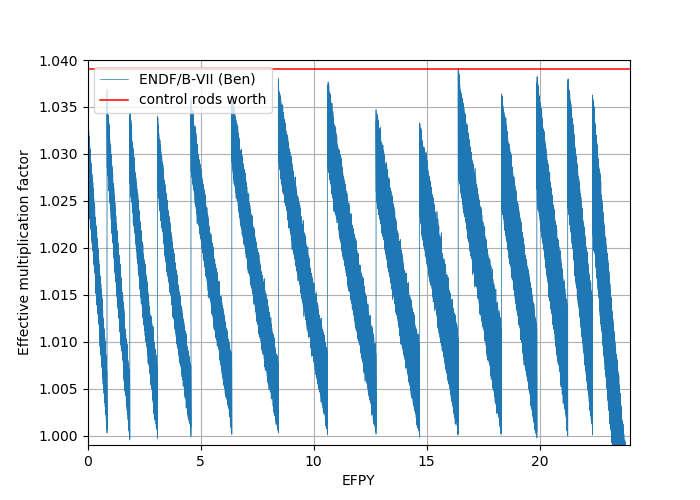

7194


In [58]:
#print(len(k_bds), len(k_bds_7_5[:641]))
keff = merge(k_bds, k_eds)
efpd = merge(days, days2)
err = merge(k_bds_err, k_eds_err)

# Initialize figure
fig_keff_2 = matplotlib.pyplot.figure(2, figsize=[7,5])
ax = fig_keff_2.add_subplot(111)
ax.grid(True)
ax.plot(efpd/365.0, keff, '-', label='ENDF/B-VII (Ben)', linewidth=0.5, markerfacecolor="None")
#ax.plot(efpd_e/365, keff_endf, '-', label='ENDF', linewidth=0.5, markerfacecolor="None")
#ax.plot(efpd/365.0, keff_7_5, '-', label='7.5d', linewidth=0.5, markerfacecolor="None")
#ax.plot(efpd_5, keff_5, '-', label='LEU 5%', linewidth=0.5, markerfacecolor="None", alpha=0.8)

ax.fill_between(efpd/365.0, keff-err, keff+err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)

ax.axhline(y=1.039, linewidth=1.1, color='r', label='control rods worth')
#ax.legend(loc=0)
ax.set_ylabel('Effective multiplication factor')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
#ax.set_xlim(0,max(days2))
#ax.set_ylim([0.75, 1.018])

#ax.set_xlim(0,600)
#ax.set_ylim(0.999, 1.04)
# zoomed 1
ax.set_xlim(0, 24)
ax.set_ylim(.999, 1.04)

ax.legend(loc=0)

fig_keff_2.show()
#fig_keff_2.savefig('/home/andrei2/Desktop/keff_3.png',bbox_inches='tight', dpi=900)
#fig_keff_2.savefig('/home/andrei2/Desktop/git/job-apps/nlabs/pres/ornl-online-repr/images/keff_tap_var_geo.png',bbox_inches='tight', dpi=900)
#print(keff[-700:-620])
print(len(keff))

In [59]:
indx = []
for i in range(1, len(keff)):
    if keff[i]-keff[i-1] > 0.031:
        indx.append(efpd[i])
        print(i*1.5)
print(indx)
print("Months between moderator rods re-configurations ", (np.diff(indx)/30))
print("Average months between moderator rods re-configurations ", (np.mean(np.diff(indx)/30)))
print("Lifetime with 15 geometries is %f years" %(indx[-1]/365.0))
print(len(k_bds), k_bds[2887:2900], days[2887:2900])

315.0
684.0
1128.0
1671.0
2331.0
3081.0
3876.0
4659.0
5364.0
5985.0
6684.0
7257.0
7755.0
8154.0
[315.0, 684.0, 1128.0, 1671.0, 2331.0, 3081.0, 3876.0, 4659.0, 5364.0, 5985.0, 6684.0, 7257.0, 7755.0, 8154.0]
Months between moderator rods re-configurations  [12.3 14.8 18.1 22.  25.  26.5 26.1 23.5 20.7 23.3 19.1 16.6 13.3]
Average months between moderator rods re-configurations  20.1
Lifetime with 15 geometries is 22.339726 years
3597 [1.00017  0.999175 0.999539 0.999246 0.999033 0.999306 0.999452 0.998634
 0.998083 0.998068 0.997928 0.99792  0.997175] [8661. 8664. 8667. 8670. 8673. 8676. 8679. 8682. 8685. 8688. 8691. 8694.
 8697.]


## Calculate LEU fuel feed rate (from Betzler ~480 kg/year)

In [71]:
feed_iso = ['U235', 'U238', 'F19', 'Li6', 'Li7']
feed_mass_endf = read_feed_h5(db_file, feed_iso)

print("ENDF/B-VII with S(a,b) from JEFF-3.1.2 case (ideal removals)")
print("Total mass of LEU salt feeded over %f years is %f t" % (efpd[2*2888]/365, sum(feed_mass_endf[:2888])))
for i in range(1+int(8664.0/365.0)):
    print("LEU feed rate during %i year %f kg/year" % (i, 1e3*sum(feed_mass_endf[i*121:(i+1)*121])))
print("LEU average feed rate %f kg/year" % (1e3*sum(feed_mass_endf[:2888]/(efpd[2*2888]/365))))
print("Total burnup %f MWd/kgU after %f years " % (read_bu_h5(db_file, 2920), days[2920]/365.0))
print("Total burnup %f MWd/kgU after %f years " % (read_bu_h5(db_file, 3540), days[3540]/365.0))

ENDF/B-VII with S(a,b) from JEFF-3.1.2 case (ideal removals)
Total mass of LEU salt feeded over 23.736986 years is 10.942176 t
LEU feed rate during 0 year 375.284072 kg/year
LEU feed rate during 1 year 448.718057 kg/year
LEU feed rate during 2 year 460.997702 kg/year
LEU feed rate during 3 year 464.184572 kg/year
LEU feed rate during 4 year 464.781567 kg/year
LEU feed rate during 5 year 464.607392 kg/year
LEU feed rate during 6 year 464.436816 kg/year
LEU feed rate during 7 year 464.021327 kg/year
LEU feed rate during 8 year 463.861565 kg/year
LEU feed rate during 9 year 463.495495 kg/year
LEU feed rate during 10 year 463.348703 kg/year
LEU feed rate during 11 year 463.090689 kg/year
LEU feed rate during 12 year 462.884634 kg/year
LEU feed rate during 13 year 462.747792 kg/year
LEU feed rate during 14 year 462.586242 kg/year
LEU feed rate during 15 year 462.450771 kg/year
LEU feed rate during 16 year 461.559965 kg/year
LEU feed rate during 17 year 460.136382 kg/year
LEU feed rate durin